In [1]:
# Import the functions provided to us
import numpy as np
from simple_grid_env import SimpleGridEnv
from clean_airport_env import CleanAirportEnv
from robot_enums import Heading
from robot_enums import Action
from plotting import ValueFunctionPlotter
from plotting import PolicyPlotter

<Figure size 720x720 with 0 Axes>

In [2]:
forward_mapper  = {0: (1, 0),
                   1: (0, 1),
                   2: (-1, 0),
                   3: (0, -1)}   

## Policy Iteration Pseudo code

**1.Initialization **

$ V(s)\in\mathbb{R}\text{ and }\pi(s)\in\mathcal{A}(s)\text{ arbitrarily for all } s\in\mathcal{S}$

**2.Policy Evaluation **

Repeat
    
$\quad \Delta \leftarrow 0$

$\quad \text{For each } s\in\mathcal{S}:$

$\qquad v \leftarrow V(s)$

$\qquad V(s) \leftarrow \sum_{s', r} p(s', r|s, \pi(s))[r+\gamma V'(s)]$

$\qquad \Delta \leftarrow \max(\Delta, |v-V(s)|)$

$\text{until } \Delta < \theta (10^{-9})$

**3.Policy Improvement**

$stablePolicy \leftarrow True$

For each $s\in\mathcal{S}:$

$\quad oldAction \leftarrow \pi(s)$

$\quad \pi(s) \leftarrow \text{argmax}_a\sum_{s', r}p(s', r|s, a)[r+\gamma V(s')]$

$\quad \text{If } oldAction \neq \pi(s), \text{then } stablePolicy \leftarrow false$

$\text{If } stablePolicy, \text{then stop and return }V\approx v_* \text{ and }\pi \approx \pi_*; \text{else go to 2}$
    

In [27]:
class GeneralPolicyIteration(object):

    def __init__(self, environment, discount_factor):
        ''' Constructs a new policy iteration class instance
        Args:
        Environment: a simpleGrid() object 
            contains the grid space, the win states, the lose states, and functions to compute dynamic updates
        Discount_factor: float, set to 1.0
        '''
        self.env = environment
        self.discount_factor = discount_factor

    def get_state_value(self, state, V, action):
        ''' Returns the state value of the given state
        Args
        ----------------------------------------
        state: tuple
            in form of (i, j, k) representing the coordinate of the cell
        V: np.array(), with shape (row, col, headings)
            represents the value grid
        action: enum
            the particular action that will be taken from this state

        Returns
        ----------------------------------------
        reward: float
            value of this state
        '''
        # Retrieves the next state, and the reward using the environment functions
        next_state, reward, terminal = self.env.dynamics(state, action)
        # Note that there was a bug in the original code in simple_grid_env.py, where the terminal state outputs were (next_state, terminal, reward) instead of (next_state, reward, terminal). This code assumes that this bug is fixed. 
        if self.env.is_terminal(state):
            # only the reward needs to be returned as there is no next state
            return reward
        else:
            # For all other cases, return the reward + discounted next state reward (as in psuedo code)
            return reward + self.discount_factor * V[tuple(next_state)]

    def policy_evaluation(self, policy, theta=1e-9, max_iterations=1e3):
        '''
        Evaluates a given policy

        Args
        ----------------------------------------
        policy: np.array(), with shape (row, col, headings)
            the policy to be evaluated
        theta: float
            for convergence
        max_iterations: int 
            default to 1e3, used to exit recursion

        Returns
        ----------------------------------------
        V: np.array(), with shape (row, col, headings)
            A value grid representing the value of every state
        '''
        # Initialise value function for each state as zero
        V = np.zeros([self.env.grid_rows, self.env.grid_cols, 4])
        delta = 0
        for _ in range(int(max_iterations)):
            for h in Heading:
                for i in range(self.env.grid_rows):
                    for j in range(self.env.grid_cols):
                        s = (i, j, h)
                        v = V[s]
                        V[s] = self.get_state_value(s, V, policy[s])
                        delta = max(delta, abs(v-V[s]))
            if delta < theta:
                return V
        return V

    def policy_improvement(self, policy, V):

        ''' Iterates the entire policy grid once by picking a new policy which maximises the state value for every state
        Args
        ----------------------------------------
        policy: np.array(), with shape (row, col, headings)
            the policy to be updated
        V: np.array(), with shape (row, col, headings)
            A value grid representing the value of every state

        Returns
        ----------------------------------------
        policy: np.array(), with shape (row, col, headings)
            updated policy grid
        stable_policy: bool
            whether or not the policy stable
        '''

        stable_policy = True
        for h in Heading:
            for i in range(self.env.grid_rows):
                for j in range(self.env.grid_cols):
                    s = (i, j, h)
                    old_action = policy[s]
                    policy[s] = np.argmax([self.get_state_value(s, V, a) 
                                            for a in list(Action)[:-1]])
                    if old_action != policy[s]:
                        stable_policy=False
        return policy, stable_policy


    def policy_iteration(self, max_iterations=1e3):

        '''Performs policy iteration and returns the converged policy and value grids.

        Args
        ----------------------------------------
        max_iteration: int, default to 1000, 
            Maximum number of iterations before automatically returned.

        Returns
        ----------------------------------------
        policy: np.array(), with shape (row, col, headings)
            final, converged policy grid
        V: np.array(), with shape (row, col, headings)
            final, converged value grid
        '''
        # Initialize a random policy
        # np.random.seed(123)
        policy = np.random.randint(0, self.env.nA, size=(self.env.grid_rows, self.env.grid_cols, len(Heading)))
        V = np.zeros([self.env.grid_rows, self.env.grid_cols, len(Heading)])

        # Create functions for plotting
        value_function_plotter = ValueFunctionPlotter()
        policy_plotter = PolicyPlotter()

        for i in range(int(max_iterations)):      
            V = self.policy_evaluation(policy)
            policy, stable = self.policy_improvement(policy, V)
            if stable:
                # Plot converged value and policy graphs 
                value_function_plotter.plot(V)
                policy_plotter.plot(policy)   
                return policy, V

    def value_iteration(self, theta=1e-9, max_iterations=1e3):
        '''Performs value iteration and returns the the optimum policy and value grids
        Args
        ----------------------------------------
        theta: float, default to 1e-9, 
            used for convergence
        max_iteration: int, default to 1000, 
            Maximum number of iterations before automatically returned.

        Returns
        ----------------------------------------
        policy: np.array(), with shape (row, col, headings)
            final, converged policy grid
        V: np.array(), with shape (row, col, headings)
            final, converged value grid
        '''
        # Initialize a random policy
        policy = np.random.randint(0, self.env.nA, size=(self.env.grid_rows, self.env.grid_cols, len(Heading)))
        V = np.zeros([self.env.grid_rows, self.env.grid_cols, len(Heading)])

        delta = 0
        for _ in range(int(max_iterations)):
            for h in Heading:
                for i in range(self.env.grid_rows):
                    for j in range(self.env.grid_cols):
                        s = (i, j, h)
                        v = V[s]
                        best_a = np.argmax([self.get_state_value(s, V, a) for a in list(Action)[:-1]])
                        V[s] = self.get_state_value(s, V, best_a)
                        delta = max(delta, abs(v-V[s]))
            if delta < theta:
                break
        for h in Heading:
            for i in range(self.env.grid_rows):
                for j in range(self.env.grid_cols):
                    s = (i, j, h)
                    policy[s] = np.argmax([self.get_state_value(s, V, a) for a in list(Action)[:-1]])
        
        # Create functions for plotting
        value_function_plotter = ValueFunctionPlotter()
        policy_plotter = PolicyPlotter()

        # Plot converged value and policy graphs 
        value_function_plotter.plot(V)
        policy_plotter.plot(policy)

        return policy, V


In [28]:
def get_environment(use_simple_grid=True):
    if use_simple_grid:
        # Simple Grid Env
        grid_rows = 3
        grid_cols = 4
        start_state = (0, 0, Heading.NORTH)

        # Simple example
        win_states = [(0, 3)]
        lose_states = [(1, 3)]

        # Simple gridworld
        robot = SimpleGridEnv(grid_rows, grid_cols, start_state, win_states, lose_states)

    else:
        
        # Creating an object of type CleanAirportEnv
        # Locations matching the grid airport
        grid_rows = 7
        grid_cols = 9
        start_state = (0, 0, Heading.EAST)
        cleaning_locations = [(0, 5), (1, 4), (1, 5), (2, 0), (2, 1), (2, 2), (4, 0), (4, 7)]
        traffic_locations = [(1, 2), (5, 1), (5, 3), (5, 5), (5, 7)]
        trapdoor_location = [(2, 8, Heading.EAST), (4, 8, Heading.EAST)]
        customs_barrier_row = 3
        # Create object with init method requirements
        robot = CleanAirportEnv(grid_rows, grid_cols, start_state, cleaning_locations, traffic_locations,
                                trapdoor_location, customs_barrier_row)
    return robot

is stable


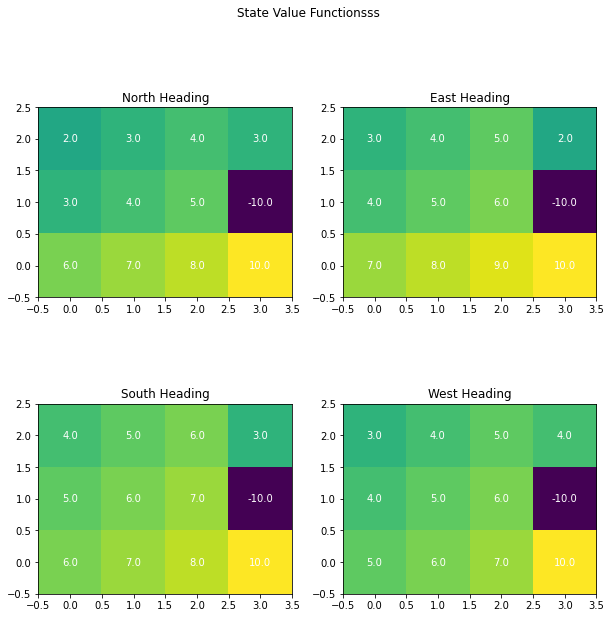

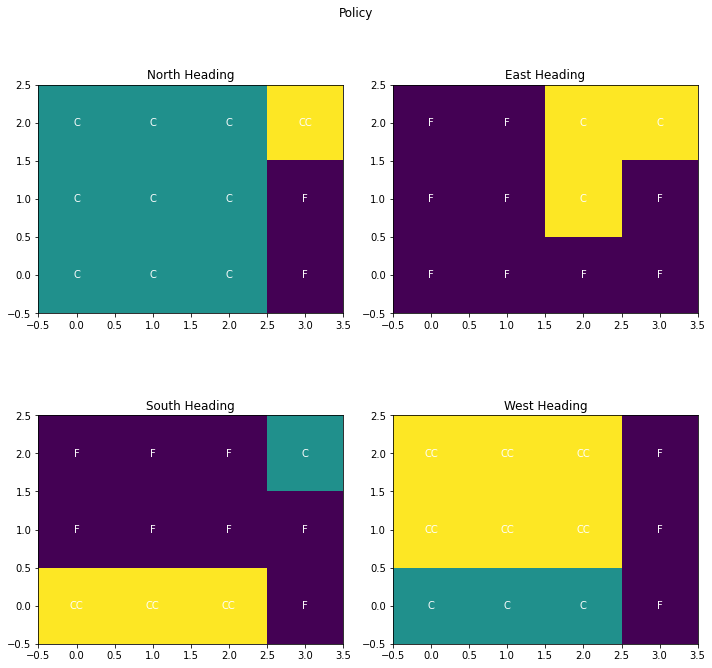

In [29]:
# Simple Grid Env
grid_rows = 3
grid_cols = 4
start_state = (0, 0, Heading.NORTH)

# Simple example
win_states = [(0, 3)]
lose_states = [(1, 3)]

# Simple gridworld
robot = get_environment(use_simple_grid = True)

# Run the requested algorithms
gpi = GeneralPolicyIteration(robot, discount_factor=1.0)

policy, value = gpi.policy_iteration()